# Accident Risk Assessment for a Car Sharing Company

The goal of this project is to predict the risk of an accident along the route of a car-sharing vehicle.

The concept of the project can be outlined as follows:

1. Develop an accident prediction model (target variable: `at_fault` in the `parties` table):

   - For the model, consider only cases where the offender is a car.
   - Select instances where the accident resulted in any vehicle damage except for the SCRATCH type.
   - Limit the modeling to data from 2012—the most recent available.
   - It is essential to incorporate the vehicle's age as a factor.

2. Based on the model, investigate the primary factors contributing to accidents. The aim is to determine if the modeling results and feature importance analysis can answer the following questions:

   - Is it possible to create an adequate driver risk assessment system when issuing a vehicle?
   - What additional factors should be considered?
   - Is it necessary to equip the vehicle with any sensors or cameras?

## Dependencies

In [202]:
!pip install SQLAlchemy
!pip install phik
!pip install shap
!pip install dtreeviz
!pip install -U scikit-learn

In [203]:
import pandas as pd
import graphviz
import shap
import dtreeviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sqlalchemy import create_engine, inspect
import phik
from phik import resources, report
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report,
                            roc_auc_score,
                            confusion_matrix,
                            PrecisionRecallDisplay,
                            precision_score)

# Plotting config
plt.rcParams["figure.figsize"] = (12,10)
sns.set_theme(palette = 'dark')
sns.set_style('whitegrid')

## Data load and primary check

In [205]:
# Conect to the database
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

In [206]:
# Check tables in database
insp = inspect(engine)
print(insp.get_table_names())

['collisions', 'case_ids', 'parties', 'vehicles']


In [207]:
case_ids = '''
SELECT *
FROM case_ids
LIMIT 5
'''
case_ids = pd.read_sql_query(case_ids, con = engine)
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [208]:
collisions = '''
SELECT *
FROM collisions
LIMIT 5
'''
collisions  = pd.read_sql_query(collisions, con = engine)
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [209]:
parties = '''
SELECT *
FROM Parties
LIMIT 5
'''
parties = pd.read_sql_query(parties, con = engine)
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [210]:
vehicles = '''
SELECT *
FROM vehicles
LIMIT 5
'''
vehicles = pd.read_sql_query(vehicles, con = engine)
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


### Interim Conclusion

The data was loaded without any issues; every table contains data and includes keys for linking between tables. All tables share the common key `case_id`.

## Statistical Analysis of Accident Factors

In [211]:
# Let's determine the number of accidents by month
q = '''
SELECT
    EXTRACT('month' FROM collision_date) as month,
    COUNT(DISTINCT case_id)
FROM
    collisions
GROUP BY
    EXTRACT('month' FROM collision_date)
'''

mcolls = pd.read_sql_query(q, con = engine)
mcolls.month = mcolls.month.astype(int)

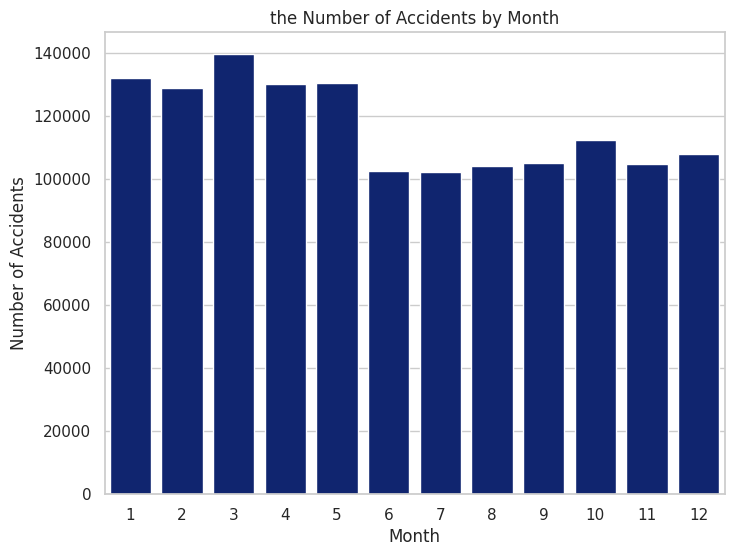

In [212]:
# Plotting
plt.figure(figsize=(8,6))
sns.barplot(data=mcolls, x='month', y='count')
plt.title('the Number of Accidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents');

**The chart shows that far more incidents occur in the first five months of the year than in the subsequent seven months.**


## Accident Risk Assessment Model

1. To build the model, we will filter for records corresponding to 'car' in the `parties` table, using the `at_fault` field from the same table as the target variable.

2. From the client's perspective, it is crucial that the model accurately predicts class 1 – driver fault. Therefore, we should employ the precision metric, which measures the accuracy of class 1 predictions using the following formula:

$
Precision = \frac{TP}{TP+FP}
$


### Original Table

This table includes all features that are at least minimally relevant for building the model. Later, through exploring the data structure, conducting statistical analysis, and performing correlation analysis, the model's input features will be filtered.

In [213]:
# SQL query
q = '''
SELECT
    p.cellphone_in_use,
    p.at_fault,
    p.party_sobriety,
    c.collision_time,
    c.location_type,
    c.weather_1,
    c.road_surface,
    c.lighting,
    c.control_device,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age

FROM
    parties p
JOIN
    collisions c
ON
    c.case_id = p.case_id
JOIN
    vehicles v
ON
    v.case_id = p.case_id
AND
    v.party_number = p.party_number
WHERE
    party_type = 'car'
AND
    c.collision_damage != 'scratch'
AND
    EXTRACT('year' FROM c.collision_date::date) = 2012
'''

# DataFrame
df = pd.read_sql_query(q, con=engine)
# DataFrame copy for analysis
df1 = df.copy()
df = df.drop('party_sobriety',axis=1)
df.head(5)

,cellphone_in_use,at_fault,collision_time,location_type,weather_1,road_surface,lighting,control_device,vehicle_type,vehicle_transmission,vehicle_age
0,0.0,1,01:50:00,highway,clear,dry,dark with street lights,none,sedan,manual,3.0
1,0.0,0,02:00:00,None,clear,dry,dark with street lights,functioning,sedan,manual,10.0
2,0.0,0,13:50:00,None,clear,dry,daylight,none,sedan,manual,1.0
3,0.0,0,16:30:00,None,clear,dry,daylight,none,sedan,manual,7.0
4,0.0,0,18:05:00,highway,raining,wet,daylight,none,sedan,auto,4.0


### Data Processing and Initial Feature Extraction

In [214]:
# Identifying implicit duplicates and standardizing missing values
for c in df.columns:
    print(c)
    print(pd.Series(df[c].unique()))
    print('--------------------------')

cellphone_in_use
0    0.0
1    NaN
2    1.0
dtype: float64
--------------------------
at_fault
0    1
1    0
dtype: int64
--------------------------
collision_time
0       01:50:00
1       02:00:00
2       13:50:00
3       16:30:00
4       18:05:00
          ...   
1431    04:47:00
1432    04:54:00
1433    04:34:00
1434    06:23:00
1435    04:51:00
Length: 1436, dtype: object
--------------------------
location_type
0         highway
1            None
2            ramp
3    intersection
dtype: object
--------------------------
weather_1
0      clear
1    raining
2     cloudy
3        fog
4    snowing
5      other
6       None
7       wind
dtype: object
--------------------------
road_surface
0         dry
1         wet
2       snowy
3    slippery
4        None
dtype: object
--------------------------
lighting
0                    dark with street lights
1                                   daylight
2                 dark with no street lights
3                               dusk or dawn

In [215]:
for c in df.columns:
    print(c)
    print(pd.Series(df[c].unique()))
    print('--------------------------')

cellphone_in_use
0    0.0
1    NaN
2    1.0
dtype: float64
--------------------------
at_fault
0    1
1    0
dtype: int64
--------------------------
collision_time
0       01:50:00
1       02:00:00
2       13:50:00
3       16:30:00
4       18:05:00
          ...   
1431    04:47:00
1432    04:54:00
1433    04:34:00
1434    06:23:00
1435    04:51:00
Length: 1436, dtype: object
--------------------------
location_type
0         highway
1            None
2            ramp
3    intersection
dtype: object
--------------------------
weather_1
0      clear
1    raining
2     cloudy
3        fog
4    snowing
5      other
6       None
7       wind
dtype: object
--------------------------
road_surface
0         dry
1         wet
2       snowy
3    slippery
4        None
dtype: object
--------------------------
lighting
0                    dark with street lights
1                                   daylight
2                 dark with no street lights
3                               dusk or dawn

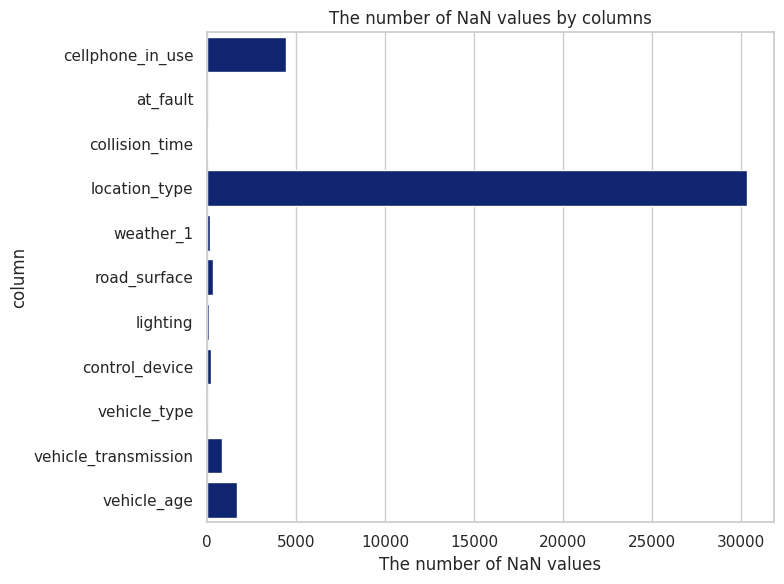

In [216]:
# Visualizing the number of NaN values
df_na_counts = df.isna().sum().reset_index().rename(columns={0: 'count'})
plt.figure(figsize=(8,6))
sns.barplot(data=df_na_counts, x='count', y='index')
plt.title('The number of NaN values by columns')
plt.ylabel('column')
plt.xlabel('The number of NaN values')
plt.tight_layout()
plt.show()

The `location_type` column contains too many NaN values and should be removed as it is not informative.  


In [217]:
# Removal
df = df.drop(columns=['location_type'])

To determine whether NaN values in the remaining columns can be filled with placeholders, we will analyze the correlation matrices of the dataframe with placeholders and with NaNs removed.  

### Correlation Analysis


In [218]:
# Dtype check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cellphone_in_use      51777 non-null  float64
 1   at_fault              56248 non-null  int64  
 2   collision_time        56160 non-null  object 
 3   weather_1             56080 non-null  object 
 4   road_surface          55900 non-null  object 
 5   lighting              56094 non-null  object 
 6   control_device        56033 non-null  object 
 7   vehicle_type          56248 non-null  object 
 8   vehicle_transmission  55389 non-null  object 
 9   vehicle_age           54554 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 4.3+ MB


In [219]:
# Convert time to seconds from the start of the day for easier processing.
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.time
df['collision_time'] = df['collision_time'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second)

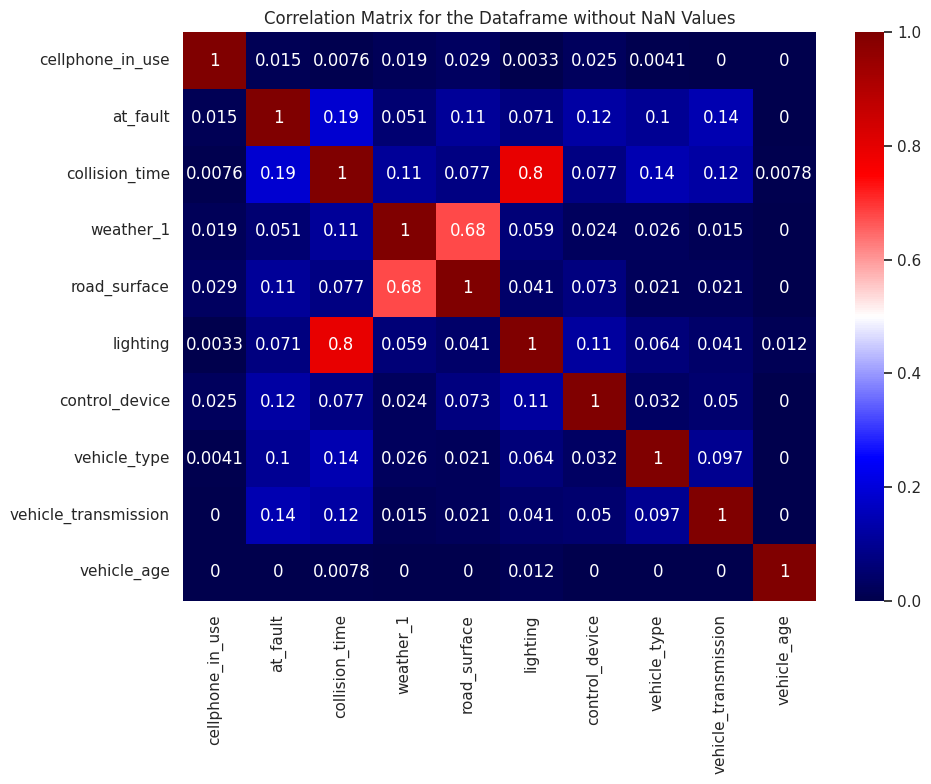

In [220]:
# Construct a correlation matrix for the dataframe without NaN values.
plt.figure(figsize=(10,8))
sns.heatmap(df.dropna().phik_matrix(interval_cols=['vehicle_age','collision_time']), annot=True, cmap='seismic')
plt.title('Correlation Matrix for the Dataframe without NaN Values')
plt.tight_layout()
plt.show()

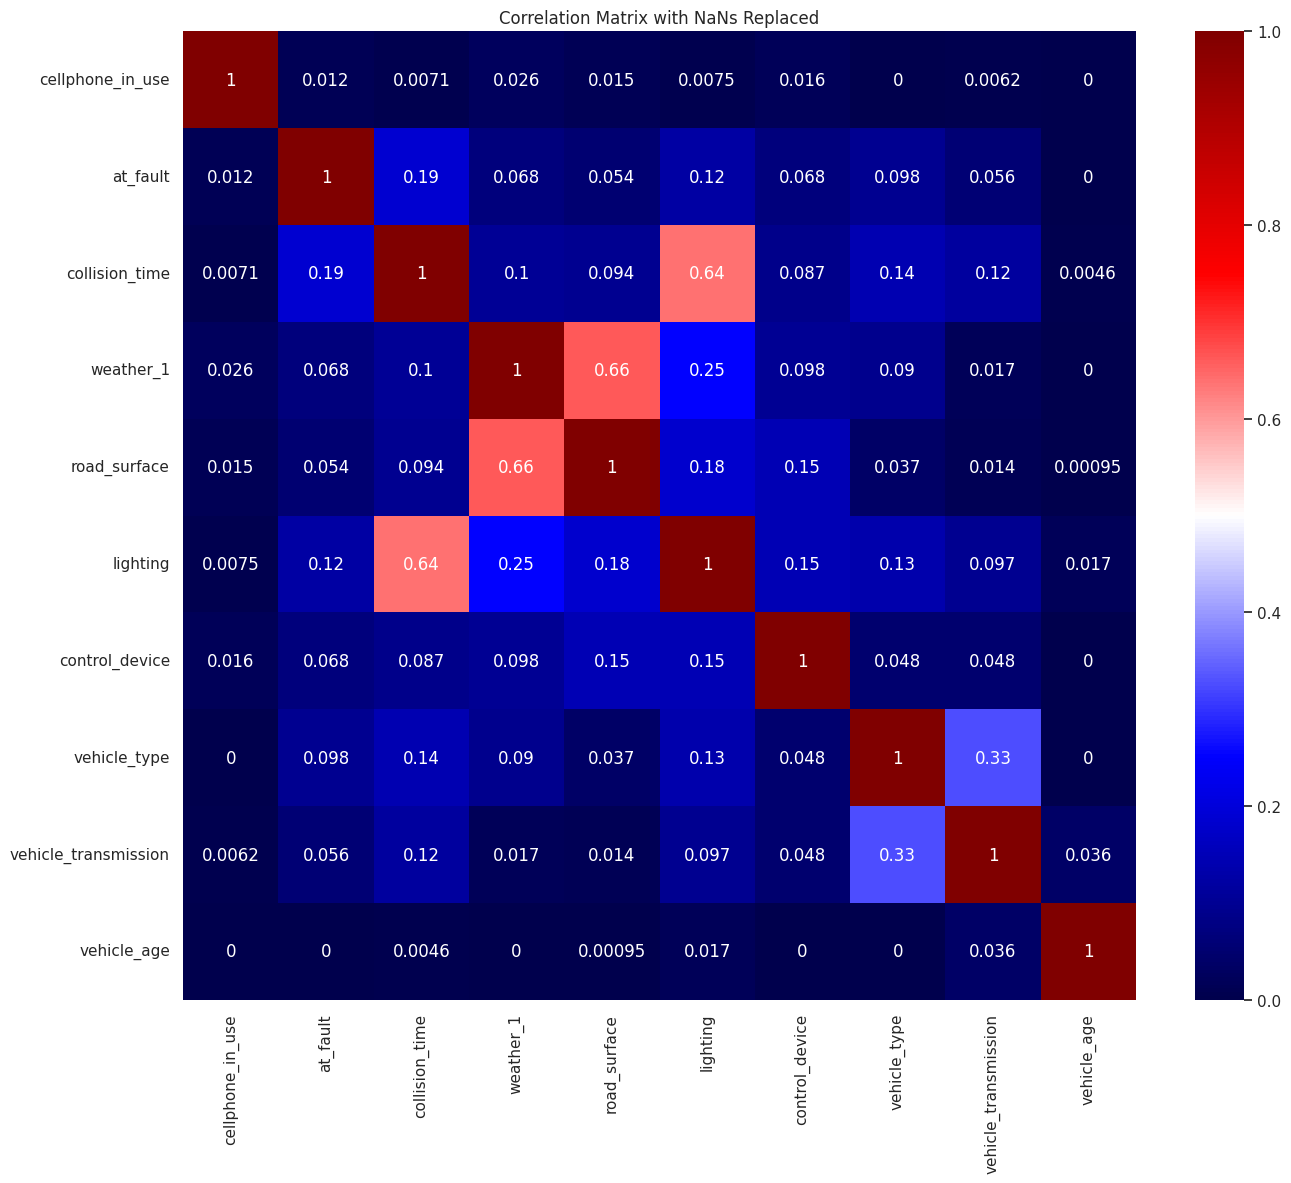

In [221]:
df_filled = df.copy()
for c in df_filled.select_dtypes(exclude='object').columns:
    df_filled[c] = df_filled[c].fillna(df_filled[c].median())
for c in df_filled.select_dtypes(include='object').columns:
    df_filled[c] = df_filled[c].fillna('unknown')
    df_filled[c] = df_filled[c].str.replace('Nan','unknown')

# Construct a correlation matrix for the dataframe with NaN values replaced by placeholders
plt.figure(figsize=(14,12))
sns.heatmap(df_filled.phik_matrix(interval_cols=['vehicle_age', 'collision_time']), annot=True, cmap='seismic')
plt.title('Correlation Matrix with NaNs Replaced')
plt.tight_layout()
plt.show()

Replacing NaN values with placeholders made the correlations more pronounced, so we will proceed with this approach.  


In [222]:
df = df_filled.copy()

In [223]:
# Examine correlations with the target variable
df_filled.phik_matrix(interval_cols=['vehicle_age', 'collision_time'])['at_fault'].sort_values(ascending=False)

,at_fault
at_fault,1.000000
collision_time,0.186219
lighting,0.123667
vehicle_type,0.097580
weather_1,0.068306
control_device,0.067879
vehicle_transmission,0.055565
road_surface,0.053619
cellphone_in_use,0.012260
vehicle_age,0.000000


Based on phik, the column `vehicle_age` has no correlation with accident liability, but the technical specifications require the mandatory use of this feature.

Additionally, the following features can be highlighted due to their low correlation with the target:

| Feature               | Correlation |
|-----------------------|-------------|
| vehicle_type          | 0.097580    |
| weather_1             | 0.068306    |
| control_device        | 0.067879    |
| vehicle_transmission  | 0.055565    |
| road_surface          | 0.053619    |
| cellphone_in_use      | 0.012260    |
| vehicle_age           | 0.000000    |


### Statistical analysis

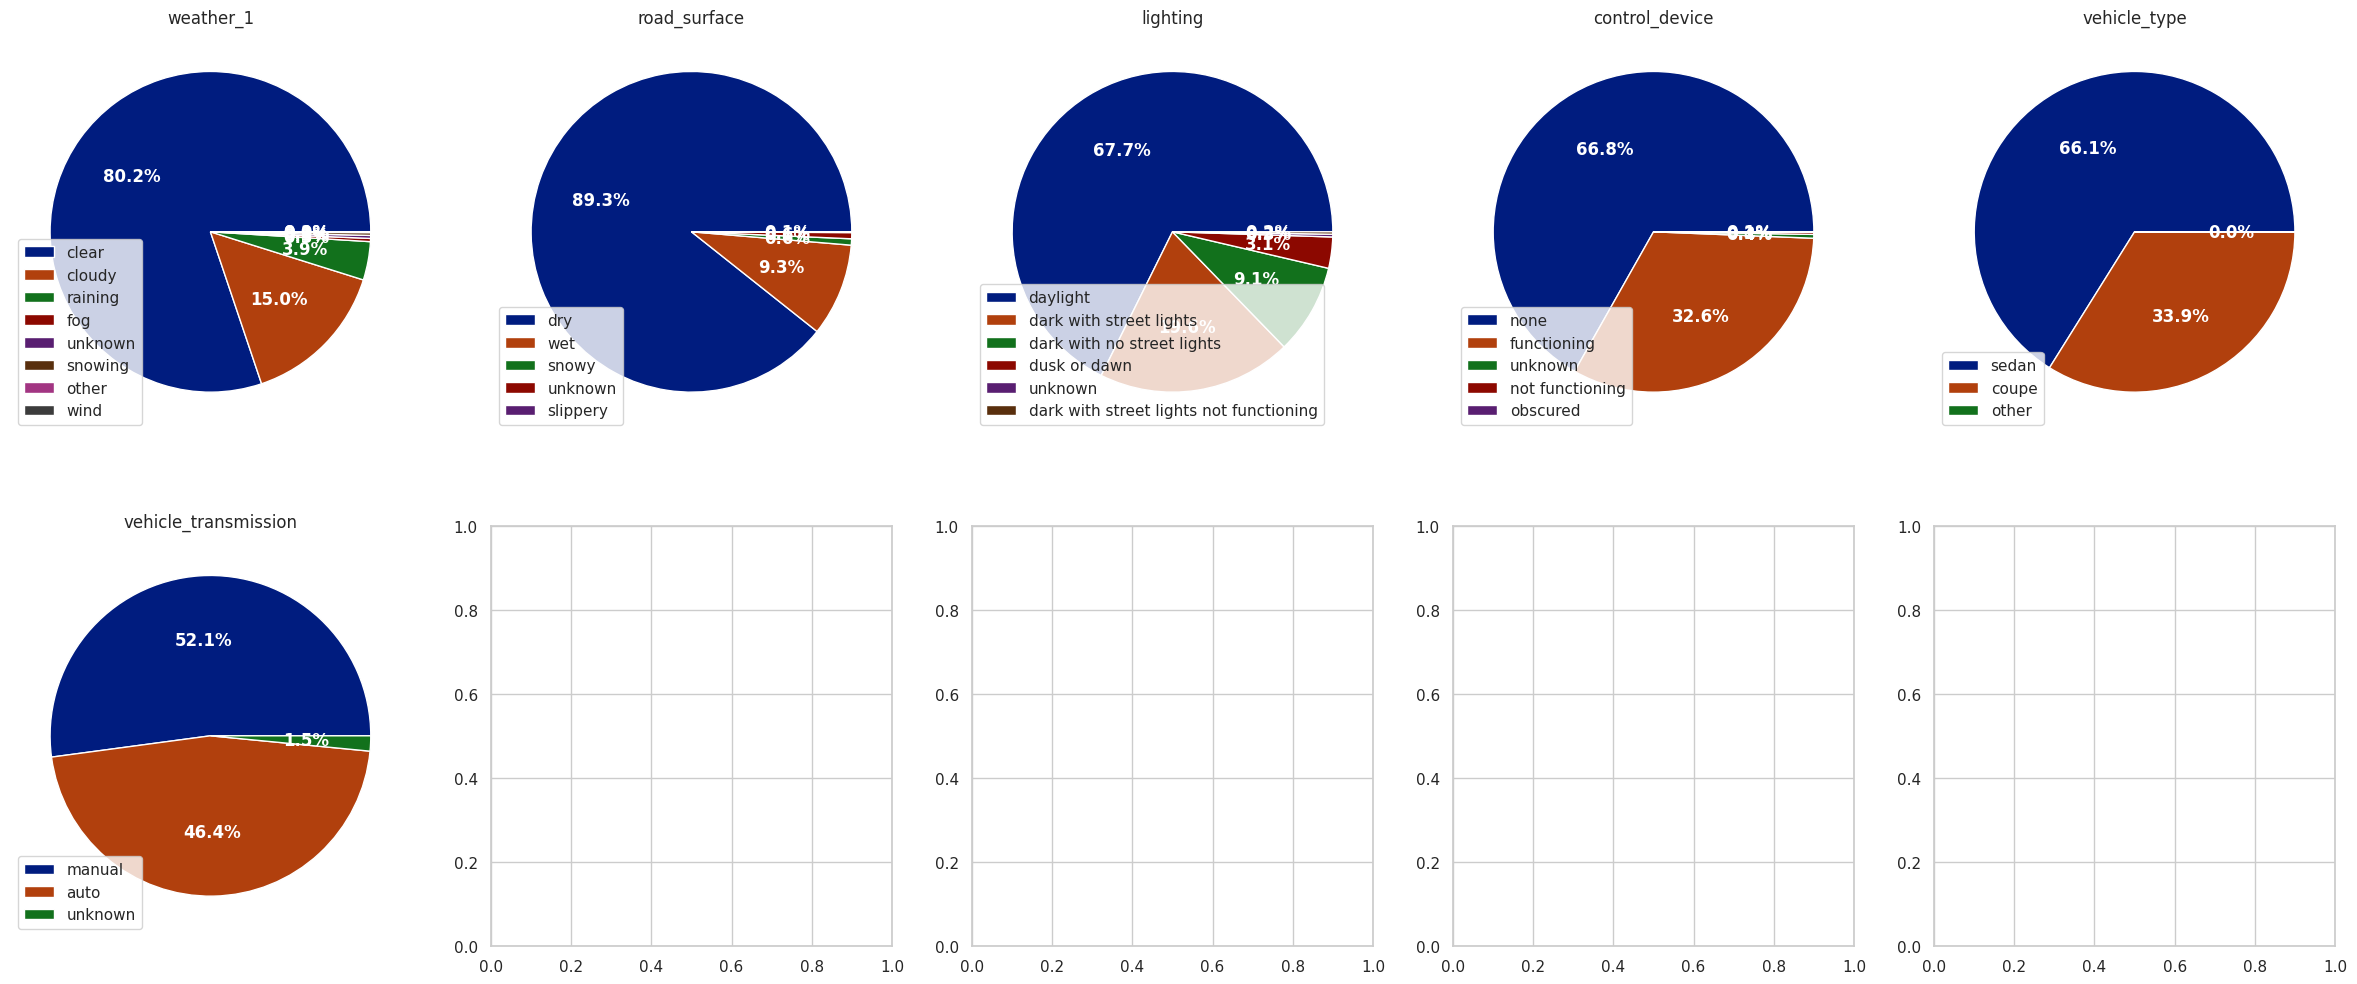

In [224]:
# Plotting diagrams for all categorical features
cat_cols = df.select_dtypes(include='object').columns
n_cols = 5
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    try:
        ax = axes[i]
        ax.pie(df[col].value_counts(),
                autopct='%1.1f%%',
                textprops={'color': 'white', 'weight': 'bold'})
        ax.legend(loc=3, labels=df[col].value_counts().index)
        ax.set_title(col)
    except:
        pass
plt.show()

Small data groups in categorical columns will not provide value when building the model but will increase the dimensionality when encoding.

In [225]:
# Removing small data groups
for c in cat_cols:
    freq = df[c].value_counts(normalize=True)
    rare = freq[freq < 0.01].index
    df[c] = df[c].replace(rare, 'other')

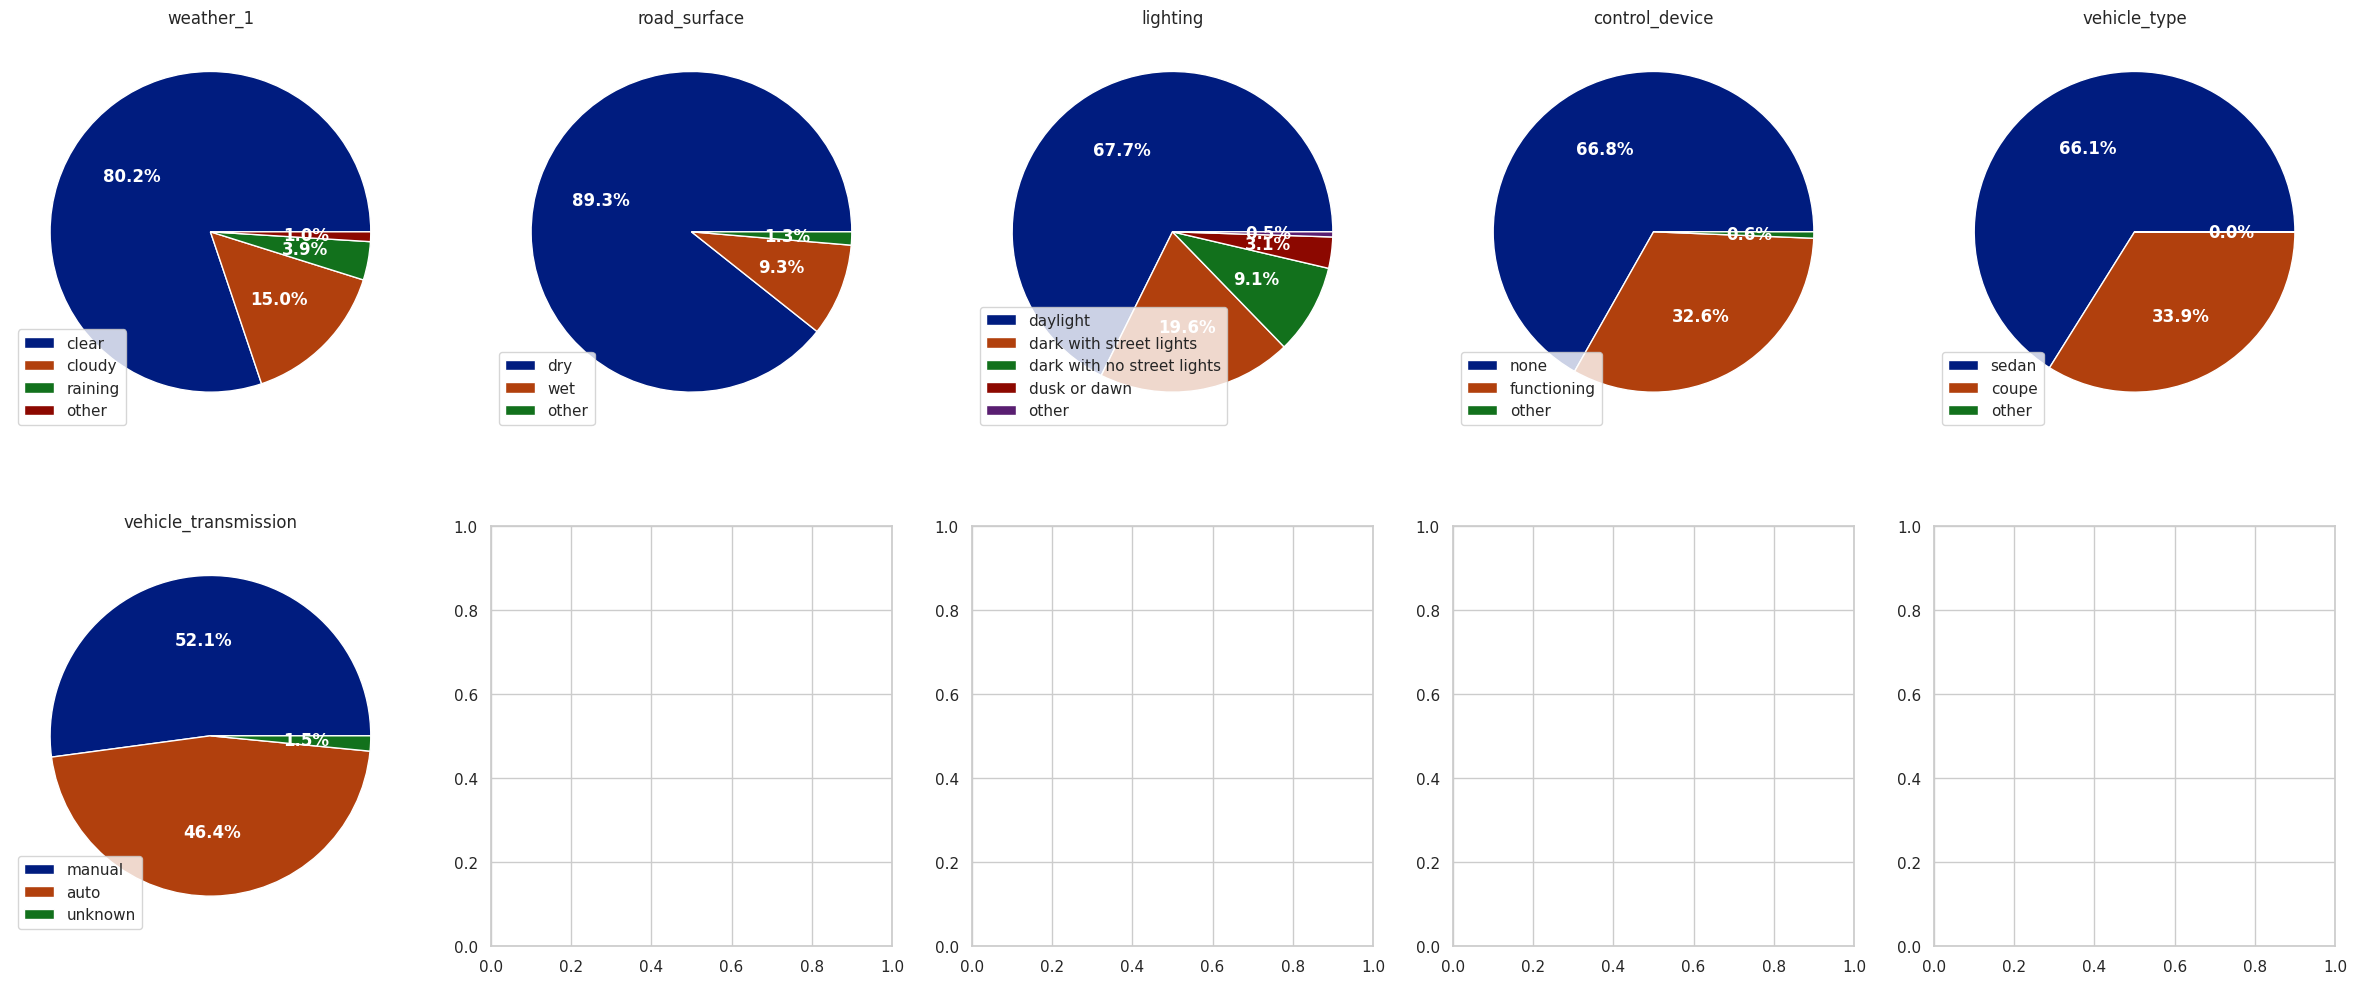

In [226]:
# Replotting diagrams for all categorical features
n_cols = 5
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    ax.pie(df[col].value_counts(),
            autopct='%1.1f%%',
            textprops={'color': 'white', 'weight': 'bold'})
    ax.legend(loc=3, labels=df[col].value_counts().index)
    ax.set_title(col)
plt.show()

Let's move on to the numerical columns.

In [227]:
num_cols = df.select_dtypes(exclude='object').columns
num_cols

Index(['cellphone_in_use', 'at_fault', 'collision_time', 'vehicle_age'], dtype='object')

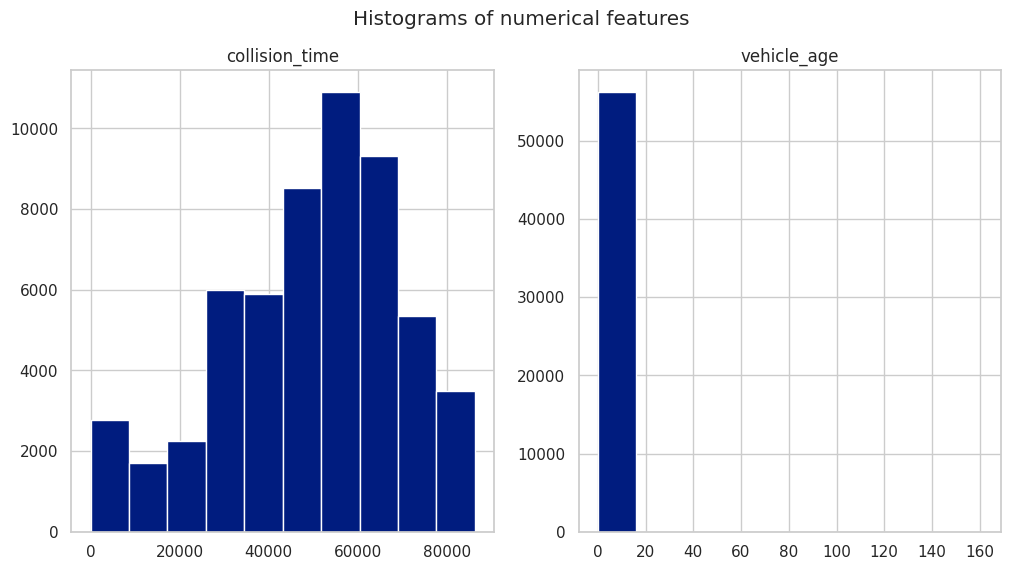

In [228]:
# Remove columns with discrete values from the list
n_cols = len(num_cols.drop(['cellphone_in_use', 'at_fault']))
# Plotting the graph
fig, axes = plt.subplots(1, n_cols, figsize=(6*n_cols, 3*n_rows))
axes = axes.flatten()
for i, col in enumerate(num_cols.drop(['cellphone_in_use', 'at_fault'])):
    ax = axes[i]
    ax.hist(df[col])
    ax.set_title(col)
fig.suptitle('Histograms of numerical features')
plt.show()


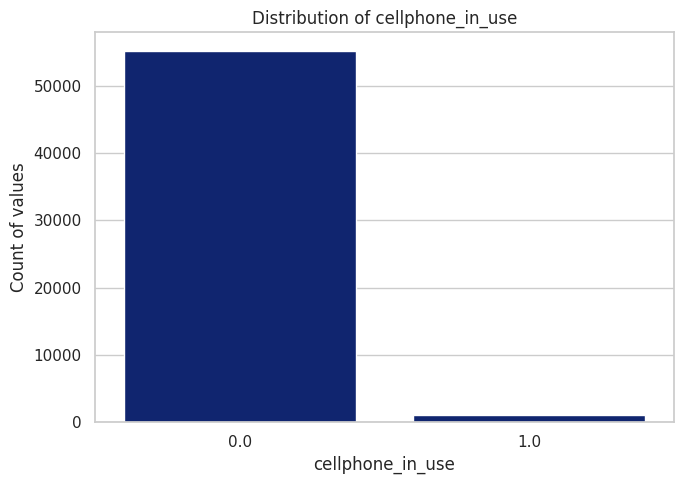

In [229]:
# Plot the distribution of cellphone_in_use
plt.figure(figsize = (7,5))
sns.countplot(data=df, x='cellphone_in_use')
plt.title('Distribution of cellphone_in_use')
plt.ylabel('Count of values')
plt.tight_layout()
plt.show()


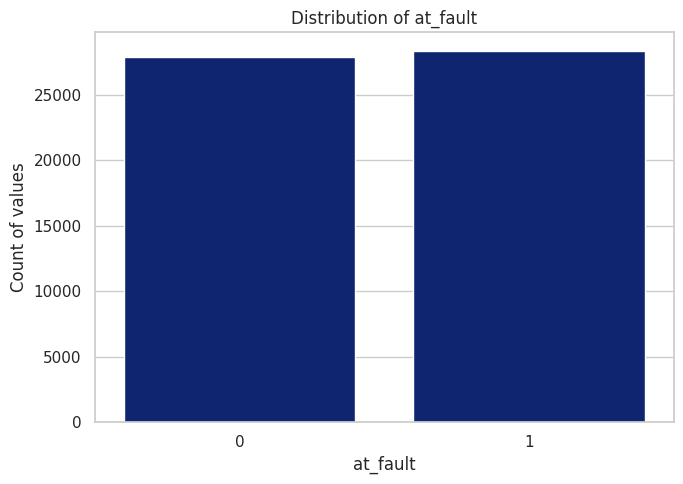

In [230]:
# Plot the distribution of at_fault
plt.figure(figsize = (7,5))
sns.countplot(data=df, x='at_fault')
plt.title('Distribution of at_fault')
plt.ylabel('Count of values')
plt.tight_layout()
plt.show()

1. Target class balance (`at_fault`) – the classes are represented in equal numbers of samples, there is no imbalance.

2. `colision_time` – the distribution is close to normal.

3. Outliers in the `vehicle_age` column.

4. `cellphone_in_use` – the classes are imbalanced, class 1 is represented in an insignificantly smaller number of samples compared to class 0, so using this column is unreasonable.


In [231]:
# cellphone_in_use removal
df = df.drop('cellphone_in_use', axis=1)

In [232]:
# Consider the highest values of vehicle age
df.vehicle_age.sort_values(ascending=False).head(10)

,vehicle_age
19884,161.0
28228,161.0
43512,19.0
734,17.0
12153,17.0
14354,17.0
7095,16.0
7085,16.0
30391,16.0
3206,16.0


There are clearly two outliers with a vehicle age of 161 years, which is clearly a technical anomaly and should be removed from the train dataset when splitting into test/train sets.

### Predicting Accident Risk

The goal of the model is to predict the target `at_fault` as accurately as possible, while it is important for the client that the model is not a black box and its decisions can be easily interpreted. The most important aspect for us is to identify the key factors leading to accidents.

Based on the above conditions, several models should be built by selecting the best hyperparameters and drawing conclusions based on feature weights.

The target values are (0,1), so this is a binary classification problem.


In [233]:
df.columns

Index(['at_fault', 'collision_time', 'weather_1', 'road_surface', 'lighting',
       'control_device', 'vehicle_type', 'vehicle_transmission',
       'vehicle_age'],
      dtype='object')

The final table for modeling includes the following features:

1. `at_fault` - Target
2. `collision_time` - Correlated with the target by phi_k, and it is quite likely that driving at certain times of the day is more dangerous.
3. `weather_1` - Weather conditions directly affect the likelihood of an accident, which is obvious from a logical standpoint. However, correlation analysis shows a low correlation with the target, so we will check what weights the model assigns to this feature.
4. `road_surface` - It is known that the road surface condition affects the likelihood of an accident, as it impacts the car's grip on the road.
5. `lighting` - Lighting also influences driving comfort, and thus the likelihood of an accident.
6. `control_device` - The state of the car's control devices can also be an important factor in accidents.
7. `vehicle_type`
8. `vehicle_transmission`
9. `vehicle_age`

Points 7-9 are technical characteristics of the vehicle, and the influence of these features on the likelihood of an accident should clearly be studied.


In [234]:
# Set RandomState for reproducibility
RS = 42

In [235]:
# Split the dataset into training and test sets
X = df.drop('at_fault', axis=1)
y = df.at_fault
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RS, stratify=y
)

# Remove outliers
out_idx = list(X_train[X_train.vehicle_age > 30].index)
X_train = X_train.drop(out_idx, axis=0)
y_train = y_train.drop(out_idx, axis=0)

In [236]:
# Check the input table for NaN values
print(X.isna().sum().values)
print(y.isna().sum())

[0 0 0 0 0 0 0 0]
0


In [237]:
# Update the lists of columns for processing
num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns

In [238]:
# Perform preprocessing
scaler = MinMaxScaler()
encoder = OneHotEncoder(sparse_output=False)

trans = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first',
                              sparse_output=False,
                              handle_unknown='infrequent_if_exist'), cat_cols)
    ],
    remainder='passthrough'
)

In [239]:
X_train = trans.fit_transform(X_train)
X_test = trans.transform(X_test)

#### Logistic Regression

In [240]:
# Start with a basic logistic regression model with hyperparameter tuning
LReg = LogisticRegression(random_state=RS, max_iter=1000)
param_grid = {
    'C': [0.05, 0.01],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}

# Configure GridSearch
grid_search = GridSearchCV(
    estimator=LReg,
    param_grid=param_grid,
    scoring='precision',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score_Lreg = grid_search.best_score_
best_model_Lreg = grid_search.best_estimator_

print(f'''
Best parameters: {best_params}
Best precision score on cross-validation: {best_score_Lreg}
''')



Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best precision score on cross-validation: 0.6056639156086399



In [241]:
# Analyze feature weights
feature_names = trans.get_feature_names_out()
weights_df = pd.DataFrame(best_model_Lreg.coef_[0], index=feature_names, columns=['weight'])
weights_df.sort_values('weight')

,weight
num__vehicle_age,-0.784182
cat__vehicle_type_sedan,-0.704173
num__collision_time,-0.539450
cat__lighting_daylight,-0.342047
cat__lighting_dusk or dawn,-0.246163
cat__lighting_other,-0.173804
cat__lighting_dark with street lights,-0.090937
cat__vehicle_type_other,0.001491
cat__weather_1_other,0.042720
cat__vehicle_transmission_unknown,0.055177


### Conclusions:

**Vehicle Age (`vehicle_age`):**  
Coefficient: -0.71. The negative weight indicates that as a vehicle's age increases, the likelihood of it being at fault in an accident decreases. This may suggest that drivers of older vehicles are more cautious or that older vehicles are used less frequently on the roads.  

**Vehicle Type (`vehicle_type_sedan`):**  
Coefficient: -0.67. This weight suggests that sedans are less likely to be at fault in accidents compared to other vehicle types (e.g., SUVs or trucks). This could be due to more cautious driving behavior or differences in how sedans are used.  

**Collision Time (`collision_time`):**  
Coefficient: -0.44. The negative weight implies that as the time of day increases (e.g., later in the evening or at night), the likelihood of an at-fault accident decreases. This may be because drivers are more cautious in low-visibility conditions or because there is less traffic at night.  

**Lighting (`lighting_daylight`):**  
Coefficient: -0.23. Daylight reduces the likelihood of a driver being at fault in an accident, which makes sense since visibility is better, lowering the risk of crashes.  

**Road Surface (`road_surface_wet`):**  
Coefficient: 0.27. A positive weight for wet road surfaces indicates that accident risk increases in slippery conditions. This highlights the importance of considering weather conditions in risk assessment.  

**Manual Transmission (`cat__vehicle_transmission_manual`):**  
Coefficient: 0.20. Using a manual transmission slightly increases the likelihood of an accident, possibly due to the added complexity of vehicle control compared to an automatic transmission, especially in heavy traffic conditions.  


#### Decision Tree

In [242]:
clf = DecisionTreeClassifier(random_state=RS,
                             criterion='entropy')
param_grid = {
    'max_depth': [15, 20, 50],
    'min_samples_split': [2, 10, 25],
    'min_samples_leaf': [10, 50, 100]
}

# Configure grid search
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='precision',
    cv=5,
    n_jobs=-1
)

# Train the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Retrieve best parameters and model
best_params = grid_search.best_params_
best_score_Dtree = grid_search.best_score_
best_model_Dtree = grid_search.best_estimator_

print(f'''
Best parameters: {best_params}
Best precision score on cross-validation: {best_score_Dtree}
''')



Best parameters: {'max_depth': 20, 'min_samples_leaf': 100, 'min_samples_split': 2}
Best precision score on cross-validation: 0.6155468085848319



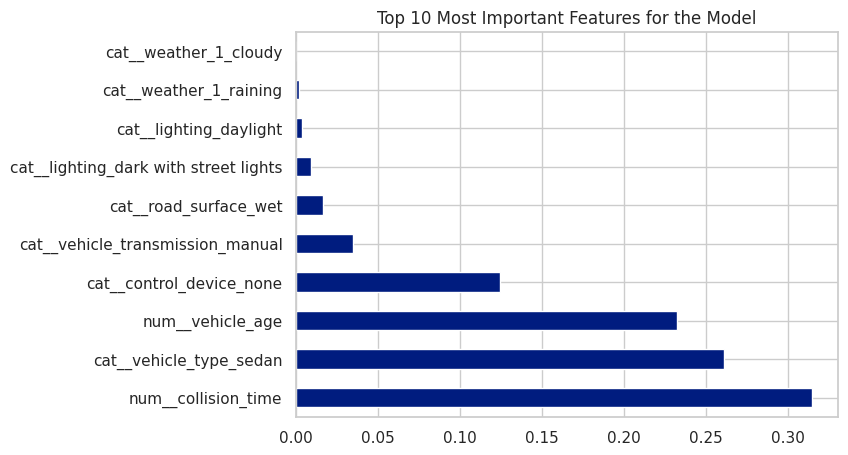

In [243]:
feature_importances = best_model_Dtree.feature_importances_

# Plot feature importance
plt.figure(figsize = (7,5))
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Most Important Features for the Model")
plt.show()

### Feature Importance Analysis

- **Collision Time (0.31)**  
  The most influential factor in the model, indicating a strong correlation between the time of the collision and accident likelihood. This suggests that certain hours (e.g., evening and night) increase the risk, possibly due to reduced visibility, driver fatigue, or high traffic density during specific periods.  

- **Vehicle Age (0.25)**  
  A significant factor showing that the age of the vehicle affects accident probability. Older vehicles may have wear and tear, leading to higher chances of technical failures and accidents.  

- **Vehicle Type - Sedan (0.25)**  
  The high importance of sedans suggests that this vehicle type plays a major role in accident probability. This might be due to their usage patterns or technical characteristics. Sedans are likely more common in urban traffic, which could increase the risk of accidents.  

- **Road Surface - Wet (0.03)**  
  While not the most critical factor, wet road conditions still impact accident likelihood. Slippery surfaces increase the risk of losing vehicle control, particularly in adverse weather.  

- **Manual Transmission (0.03)**  
  Vehicles with manual transmissions show a slightly higher risk of accidents. This could be attributed to the added complexity of driving a manual car, requiring more attention and coordination, especially in challenging conditions.  

- **Lighting - Dark with Street Lights (0.01)**  
  Nighttime driving, even with street lights, influences accident probability. Despite illumination, nighttime conditions may still present challenges for drivers, potentially reducing visibility and increasing collision risk.


#### Random Forest

In [244]:
rf = RandomForestClassifier(random_state=RS, n_jobs=-1)

param_grid = {
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [150, 200, 250],
    "bootstrap": [True, False],
    'criterion': ['entropy', 'gini']
}

# Grid search setup
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='precision',
    cv=5,
    n_jobs=-1
)

# Train the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and model
best_params = grid_search.best_params_
best_score_RForest = grid_search.best_score_
best_model_RForest = grid_search.best_estimator_

print(f'''
Best parameters: {best_params}
Best precision score on cross-validation: {best_score_RForest}
''')


Best parameters: {'bootstrap': False, 'criterion': 'entropy', 'min_samples_leaf': 200, 'min_samples_split': 5}
Best precision score on cross-validation: 0.6372207805740256



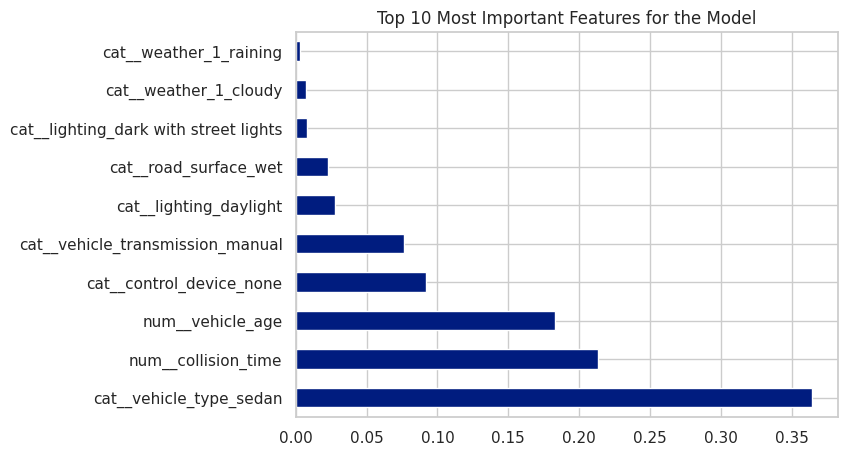

In [245]:
feature_importances = best_model_RForest.feature_importances_

# Plot feature importance
plt.figure(figsize = (7,5))
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Most Important Features for the Model")
plt.show()

### Best Model Search

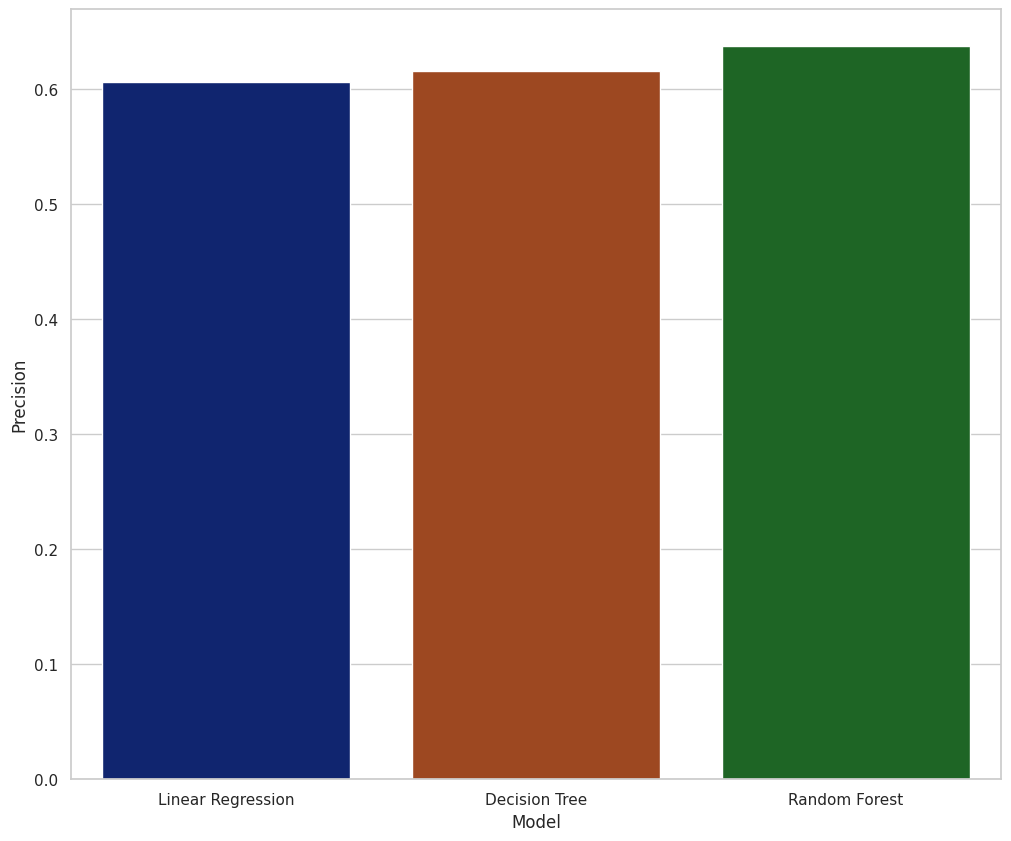

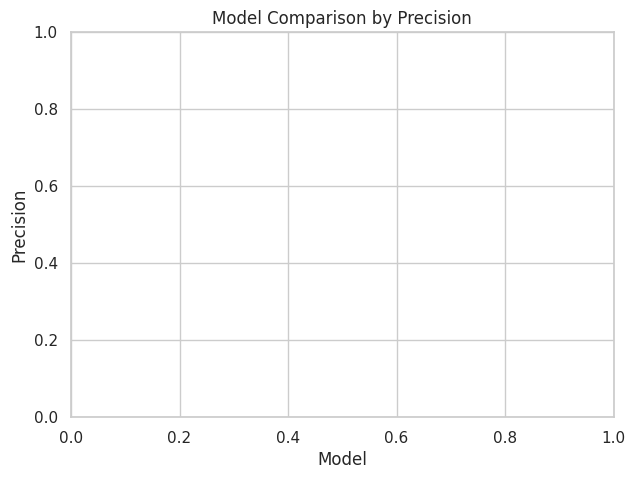

In [246]:
# Creating a table to compare models
models = pd.DataFrame(
    {
        'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
        'Precision': [best_score_Lreg, best_score_Dtree, best_score_RForest]
    }
)

plt.figure()
ax = sns.barplot(data=models,
                 x='Model',
                 y='Precision',
                 hue='Model',
                 palette='dark')

# Setting titles
plt.figure(figsize = (7,5))
plt.title('Model Comparison by Precision')
plt.xlabel('Model')
plt.ylabel('Precision')

plt.show()

The best model by precision is Random Forest. Let's check the metric on the test dataset


In [247]:
# Evaluating the model on the test dataset
RF_pred = best_model_RForest.predict(X_test)

print(f'Precision for Random Forest = {precision_score(y_test, RF_pred)}')


Precision for Random Forest = 0.6340265269363026


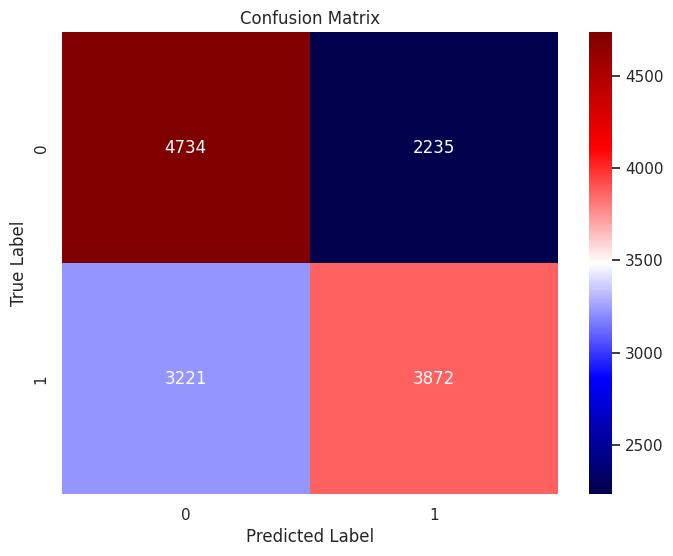

In [248]:
# Creating the confusion matrix
RF_pred = best_model_RForest.predict(X_test)
cm = confusion_matrix(y_test, RF_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='seismic')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Insights Based on the Model's Confusion Matrix:

**False Negative Predictions (3257 cases):**  
These values indicate that the model predicted no accident for a route, but an accident actually occurred. In real-world scenarios, such errors can lead to unforeseen risks.  

- **Business Risk:** False negatives may result in drivers who are likely to be involved in accidents receiving vehicles without increased monitoring, increasing the risk of additional repair costs.  
- **Recommendation:** Consider increasing attention to these cases, possibly by equipping vehicles with additional sensors or tightening requirements for drivers on specific routes.  

**False Positive Predictions (2264 cases):**  
In these cases, the model predicted a high probability of an accident, but no accident actually occurred.  

- **Business Risk:** False alarms may lead to excessive caution, such as stricter measures when issuing a vehicle, which could limit service availability for low-risk customers.  
- **Recommendation:** Analyze additional parameters or factors to reduce the number of false alarms, such as considering weather conditions, time of day, and road conditions.  

**Prediction Accuracy (4705 True Negatives and 3836 True Positives):**  
The model correctly classified a significant number of routes as either safe or risky, providing valuable insights for the company.  

- **Business Opportunities:** These insights can be used to develop an adaptive system where customers predicted to be safer may receive benefits such as discounts or priority service.  
- **Recommendation:** Based on accurate predictions, develop a reward program for safer customers, which could help improve the overall risk profile of the car-sharing service.  


**Now let's look op PR curve and make some conclusions about prediction quality.**

<Figure size 600x600 with 0 Axes>

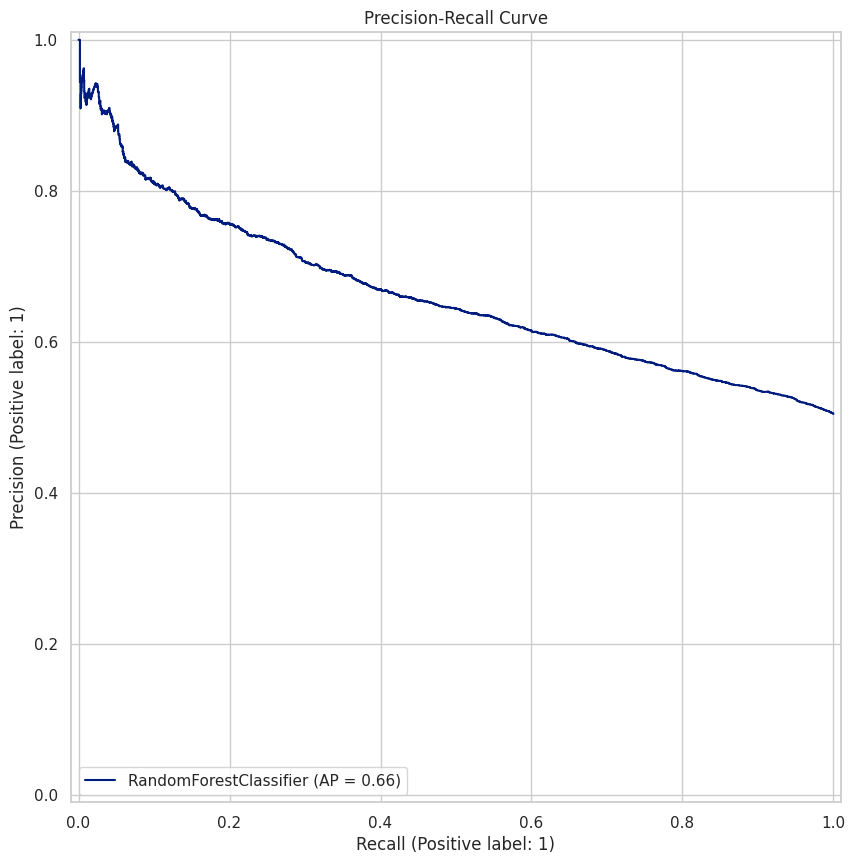

In [249]:
plt.figure(figsize=(6, 6))
display = PrecisionRecallDisplay.from_estimator(
   best_model_RForest, X_test, y_test)
_ = display.ax_.set_title("Precision-Recall Curve")

### Interpretation of the Precision-Recall Curve:

**Precision:**  
Indicates the percentage of predicted accidents that were actually caused by the driver. High precision means the model makes fewer false positive predictions (incorrectly classified as driver’s fault).  

**Recall:**  
Shows the percentage of all actual accident-causing drivers that the model correctly identified. High recall means fewer false negatives (missed driver-caused accidents).  

### PR Curve Analysis:

- The graph shows that as recall increases, precision decreases. This is typical behavior since, when trying to capture more positive cases, the model also captures more false positives, reducing precision.  
- At low recall levels, precision is close to 1.0, meaning the model is very confident in its predictions. However, such confidence can lead to missing a significant number of driver-caused accidents (low recall).  
- When recall reaches 0.5, precision drops to approximately 0.6. This indicates that to achieve a balanced level of recall and precision, the model must sacrifice precision to cover more driver-caused accidents.  

### AP Metric (Average Precision):

- The graph indicates that AP (Average Precision) is **0.66**. This is a measure of the overall model performance and reflects its average ability to distinguish between driver-caused and non-driver-caused accidents.  

Let's analyze the impact of the body type on the target variable, as this feature was identified as important by the models.

<ipython-input-250-e996a569f0ae>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


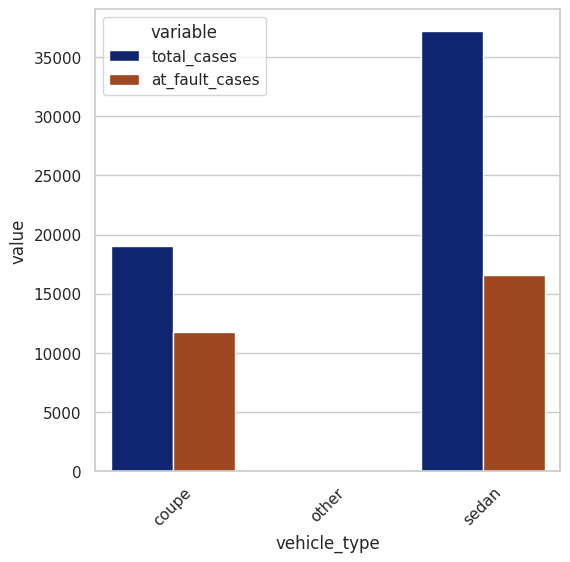

In [250]:
df_grouped = df1.groupby('vehicle_type').agg(
    total_cases=('at_fault', 'size'),
    at_fault_cases=('at_fault', 'sum')
).reset_index()

# Plotting
plt.figure(figsize=(6, 6))
plot = sns.barplot(data=df_grouped.melt(id_vars='vehicle_type',
                                 value_vars=['total_cases', 'at_fault_cases']),
            x='vehicle_type', y='value', hue='variable')

plot.set_xticklabels(plot.get_xticklabels(), rotation=45);

The graph shows that sedan drivers are less likely to be involved in accidents than coupe drivers in terms of the total number of accidents and the number of accidents due to driver fault.

# General Summary and Recommendations for the Client

## What has been done during the project:

1. Data extraction from the database via SQL query.
2. Hypotheses tested:

    2.1 **Hypothesis**: The likelihood of a driver being at fault in an accident depends on the type of gearbox and the type of road. **Result**: The hypothesis is confirmed; drivers of vehicles with manual transmissions are more likely to be at fault in accidents on ramps and highways.

    2.2 **Hypothesis**: The likelihood of a driver being at fault in an accident depends on the combination of vehicle body type and road surface conditions. **Result**: The hypothesis is confirmed; the worst fault-to-incident ratio is observed for coupes and minivans. Moreover, the worst values for these body types occur on sections of roads with loose materials or flooding.

3. Development of a risk assessment model for accidents:

    3.1 A table of initial features was compiled through an SQL query to the database.
    3.2 Data preprocessing was performed.
    3.3 Secondary feature selection for the model was conducted based on statistical and correlation analysis.
    3.4 Hyperparameter tuning was performed using grid search to find the best model.
    3.5 To identify the most significant factors, three models were built: linear regression, decision tree, and random forest. Model metrics:
        LinReg - precision = 0.61
        RandomTree - precision = 0.62
        RandomForest - precision = 0.64

## Recommendations

1. **Optimization of vehicle usage based on age**
   - **Vehicle condition monitoring**: Older vehicles have an increased risk of being involved in accidents. It is recommended to enhance monitoring of vehicle conditions as they age, and potentially set stricter limits on mileage and age for vehicles in the fleet.
   - **Fleet renewal**: Regular fleet updates based on vehicle age will reduce accident risks and potential maintenance costs. This could also improve user experience by offering newer and more reliable vehicles.

2. **Accounting for time of day when planning routes and issuing vehicles**
   - **Avoiding peak accident hours**: Time of day, especially evening and night hours, significantly impacts accident likelihood. If possible, restrict access to the service during high-risk hours (e.g., late evening and night) or warn drivers about elevated risks.
   - **Insurance rate adjustments**: Set higher insurance rates for trips during high-risk hours, compensating for the increased probability of accidents at these times.

3. **Training and raising requirements for drivers of manual transmission vehicles**
   - **Driver training**: Since driving a vehicle with a manual transmission requires more attention and skill, it is recommended to conduct additional training for drivers who prefer such vehicles or impose mandatory skill level requirements.
   - **Vehicle selection**: Where possible, prioritize vehicles with automatic transmissions, especially for less experienced drivers, as this reduces the likelihood of accidents.

4. **Considering road conditions**
   - **Route selection based on road surface and traffic management**: Roads with wet surfaces and no traffic signals or signs increase accident likelihood. When selecting routes and vehicle deployment areas, these factors should be taken into account.
   - **Informing drivers about road conditions**: Providing information about road conditions (e.g., wet surfaces after rain) will help drivers make more informed decisions and drive more cautiously.

5. **Considering weather conditions**
   - **Warnings about adverse weather conditions**: Although rain and cloud cover did not show significant impact on accident likelihood in the models, it is still recommended to inform drivers about adverse weather conditions and remind them to exercise caution in such conditions.
   - **Weather data monitoring**: In the future, the company could consider integrating real-time weather data to better predict accident risks and promptly inform drivers.

6. **Ensuring safety measures for sedans**
   - **Enhanced measures for sedans**: Sedans are, based on the analysis, more frequently involved in accidents. It may be worth reconsidering their usage, such as providing additional insurance or selecting less risky routes for them.
   - **Specific requirements for usage**: If sedans dominate the fleet, consider implementing additional control measures, such as regular maintenance or restrictions on usage times.

7. **Additional safety measures**
   - **Installing monitoring equipment**: Safety sensors and cameras can help collect data on road conditions, weather, time of day, and driver behavior, which will improve model predictions and allow for more effective risk management.
   - **Developing a dynamic pricing system**: Increasing rental costs based on risk factors (e.g., time of day, vehicle age, weather conditions) can help offset potential accident-related losses and incentivize drivers to behave more safely.
